<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/spike2_peaks_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo -q

     |████████████████████████████████| 639 kB 11.6 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch,spectrogram, decimate, savgol_filter, find_peaks
from scipy.fft import fft
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import neo
import gc
import warnings
warnings.simplefilter("ignore")

In [194]:
class Spike2:
    '''Class to open and manipulate Spike2 data'''
    import neo

    def __init__(self, data_path):
        self.path = data_path
        self.reader = neo.io.Spike2IO(filename=self.path, try_signal_grouping=False)
        self.sf = self.reader.get_signal_sampling_rate(0)
        self.data = self.read_data()
        self.cleaned = False
        self.downsampled = False
        self.noise_tresh = 10000.
        self.sample_tresh = 0. 
        self.peaks_pos = None
        self.peaks_neg = None

    def get_data(self):
        '''Get data'''
        return self.data
    
    def get_sample_rate(self):
        '''Get sample rate'''
        return self.sf

    def get_pos_peaks(self):
        '''Get positive peaks'''
        return self.peaks_pos

    def get_neg_peaks(self):
        '''Get positive peaks'''
        return self.peaks_neg

    def set_sample_tresh(self, tresh):
        self.sample_tresh = tresh 
        print('sample treshold set')

    def set_noise_tresh(self, tresh):
        self.noise_tresh = tresh 
        print('noise treshold set')

    def read_data(self):
        '''
        Read the data from Spike2 and remove DC component
        '''
        raw_data  = self.reader.read(lazy=False)[0]
        for seg in raw_data.segments:
            raw_data = np.mean(seg.analogsignals[0], axis=1)
        raw_data = np.asarray(raw_data)
        raw_data = raw_data - raw_data.mean()
        return raw_data

    def downsample(self, factor=10):
        '''Downsample the data by a factor, default=10
        Input:
            int:factor
        '''
        if self.downsampled:
            print(f'Data already downsampled to {self.sf}')
            return None
        else:
            self.data = decimate(self.data, factor,ftype='fir')
            print(f'new sample rate {self.sf/factor}')
            self.downsampled = True
            self.sf = self.sf/factor
            return None
    
    def clean_big_noise(self):
        '''Attempt to clean big noise from the recording by finding
        peaks above or below treshold and remove 2s of data around peak.
        '''
        if not self.noise_tresh:
            print('First set the noise treshold.')
            return None
        if self.cleaned:
            print('Big noise already removed!')
            return None

        print('Use with caution, just for big noise in the data.')
        self.cleaned = True
        pos_idxs = find_peaks(self.data, height=self.noise_tresh)[0]
        print(self.noise_tresh)
        for idx in pos_idxs:
            try:
                self.data[idx-5000:idx+5000] = 0
            except:
                continue
        neg_idxs = find_peaks(-self.data, height=self.noise_tresh)[0]
        for idx in neg_idxs:
            try:
                self.data[idx-5000:idx+5000] = 0
            except:
                continue        
        print(f'Removed {len(pos_idxs)+len(neg_idxs)} peaks.')  
        pass  
         

    def select_tresh(self, tresh, zoom=None, sections=10, save_name=None):
        '''
        Function to help select treshold for analysis
        '''
        if zoom > sections:
            print('Zoom needs to be smaller than sections')
            return None
        dy = savgol_filter(self.data, window_length=33, polyorder=1, deriv=0)
        if zoom:
            tsh = tresh * dy.std()
            temp = np.array_split(dy, sections)
            dy = temp[zoom]
        else:
            tsh = tresh * dy.std()
        print(f'Use this value to set the treshold: {tsh:.0}')
        pos_tsh = [tsh]*len(dy)
        neg_tsh = [-tsh]*len(dy)
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid", {'axes.grid' : False})
        time = np.arange(dy.size) / self.sf
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.plot(time, dy, lw=1.5, color='k')
        ax.locator_params(axis='x', nbins=25)
        ax.plot(pos_tsh)
        ax.plot(neg_tsh)
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('uV')
        ax.set_xlim([time.min(), time.max()])
        sns.despine()
        if save_name:
            plt.savefig(f'{save_name}.jpg')
        else:
            plt.show()
        plt.close()

    def plot_peaks(self, save_name=None):

        sns.set_style("whitegrid", {'axes.grid' : False})
        dy = savgol_filter(self.data, window_length=33, polyorder=1, deriv=0)
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,5), gridspec_kw={'height_ratios': [4, 1]})

        ax[0].plot(dy)
        ax[0].plot(self.peaks_pos, dy[self.peaks_pos], "x")
        ax[0].plot(self.peaks_neg, dy[self.peaks_neg], "x")
        ax[0].plot(np.ones_like(dy)*self.sample_tresh, "--", color="gray")
        ax[0].plot(np.ones_like(dy)*-self.sample_tresh, "--", color="gray")
        ax[1].eventplot(positions=self.peaks_pos, data=dy, linewidths=.4, linelengths=.4)
        ax[1].set_xlim(0, dy.size)        
        if save_name:
            plt.savefig(f'{save_name}.jpg')
        else:
            plt.show()
        plt.close()

    def calculate_sample_peaks(self):
        '''Find sample peaks '''

        dy = savgol_filter(self.data, window_length=33, polyorder=1, deriv=0)
        dist = 200
        f_data = savgol_filter(dy, window_length=33, polyorder=1, deriv=0)
        peaks_neg = find_peaks(-f_data, height=self.sample_tresh, width=[50], distance=dist)[0]
        peaks_pos = find_peaks(f_data, height=self.sample_tresh, width=[50], distance=dist)[0]
        
        while abs(len(peaks_neg) - len(peaks_pos)) != 0:
            tester = set(peaks_pos)
            peaks_neg = list(peaks_neg)
            peaks_pos = list(peaks_pos)
            for n in peaks_neg:
                vicinos = set(range(n-dist, n+dist))
                if len(tester.intersection(vicinos)) == 0:
                    peaks_neg.remove(n)
            tester = set(peaks_neg)
            for n in peaks_pos:
                vicinos = set(range(n-dist, n+dist))
                if len(tester.intersection(vicinos)) == 0:
                    peaks_pos.remove(n)
            peaks_pos = np.asarray(peaks_pos)
            if dist < 130:
                break
            else:
                dist = dist-10
        self.peaks_pos = np.asarray(peaks_pos)
        self.peaks_neg = np.asarray(peaks_neg)
        print(f'Found {len(peaks_pos)} positive and {len(peaks_neg)} negative peaks')
        pass

    def calc_peak_amplitudes(self):
        
        #Assuming they are the same event (NEED TO CONFIRM with loads of data)
        amp = []
        if self.peaks_pos == self.peaks_neg:
            for p,n in zip(self.peaks_pos, self.peaks_neg):
                amp.append(p-n)
            return np.asarray(amp)
        else:
            print('Not implemented for this dataset')
        pass

    def plot_data(self, save_name=None):

        '''Plot the entire recording use save name to save it in jpg
        '''
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid", {'axes.grid' : False})
        time = np.arange(self.data.size) / self.sf
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.plot(time, self.data, lw=1.5, color='k')
        ax.locator_params(axis='x', nbins=25)
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('uV')
        ax.set_xlim([time.min(), time.max()])
        sns.despine()
        if save_name:
            plt.savefig(f'{save_name}.jpg')
        else:
            plt.show()
        plt.close()

# Measurement functions
def calc_mov_average(self, arr, window_size=60):
    window_size = window_size*500
    if window_size % 2 ==0:
        window_size = window_size+1
    i = 0
    arr = arr[30:-30]
    moving_averages = []
    while i < len(arr) - window_size + 30:
        window_average = round(np.sum(arr[
        i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 30
    return moving_averages


**First define get the full path of the recording to be analysed**

new sample rate 500.0


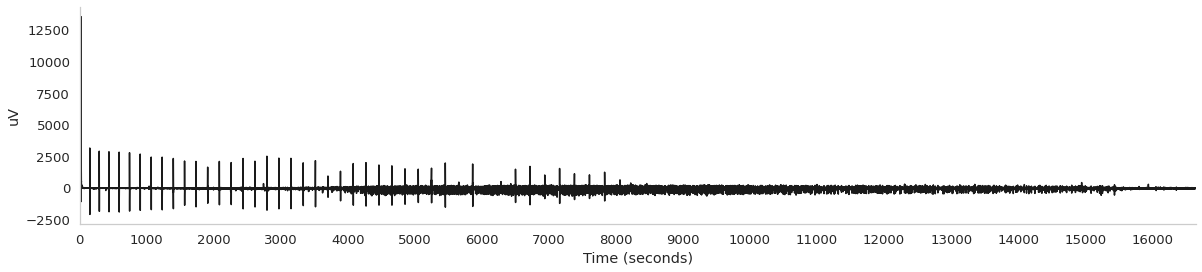

In [200]:
filename='/content/drive/MyDrive/aHuman_data_Mark/laura_sample/220322_002.smr'
# Load the sample
rec = Spike2(filename)
# Downsample the data to 1/10 of the current sample rate (helps with memory)
rec.downsample()
rec.plot_data()

Use this value to set the treshold: 7e+02


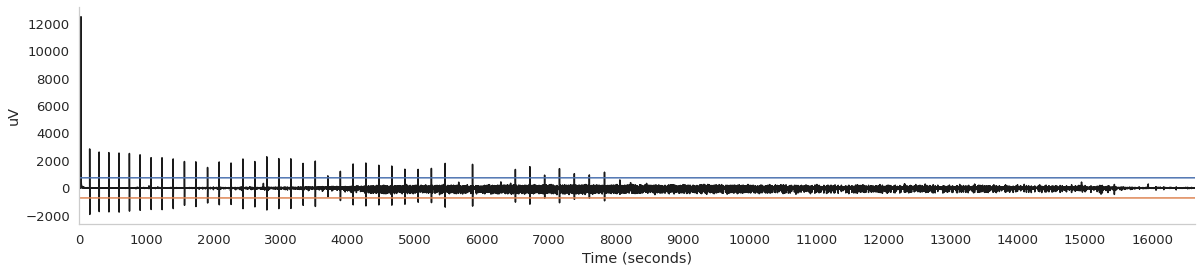

In [201]:
rec.select_tresh(6.5, zoom=0, sections= 5)

noise treshold set
Use with caution, just for big noise in the data.
600.0
Removed 358 peaks.


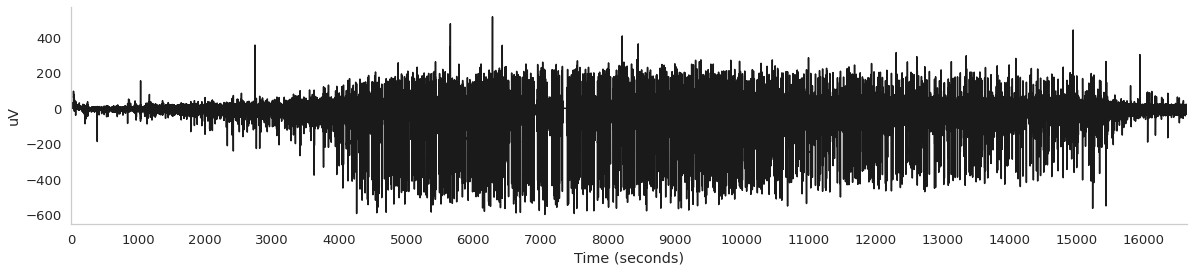

In [196]:
rec.set_noise_tresh(6e+02)
rec.clean_big_noise()
rec.plot_data()

**Plot using zoom and section to find the best treshold to remove high amplitude noise**

Sections ->  divide the entire recording in different sections

Zoom -> select one of the sections to be plotted

    Ex: rec.select_tresh(5, zoom=1, sections= 10)
    
Divide the recording in 10 section and plot the section 1



Use this value to set the treshold: 1e+02


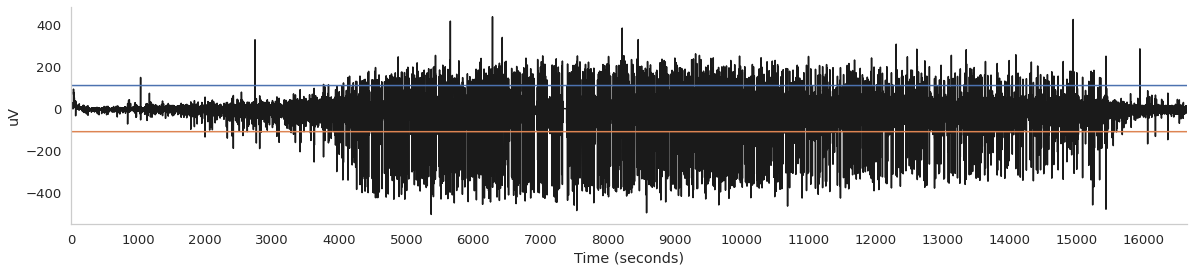

In [197]:
# keep ploting this line [shit+enter], until you are confortable with the treshold 
rec.select_tresh(3.5, zoom=0, sections= 5)

sample treshold set
Found 473 positive and 473 negative peaks


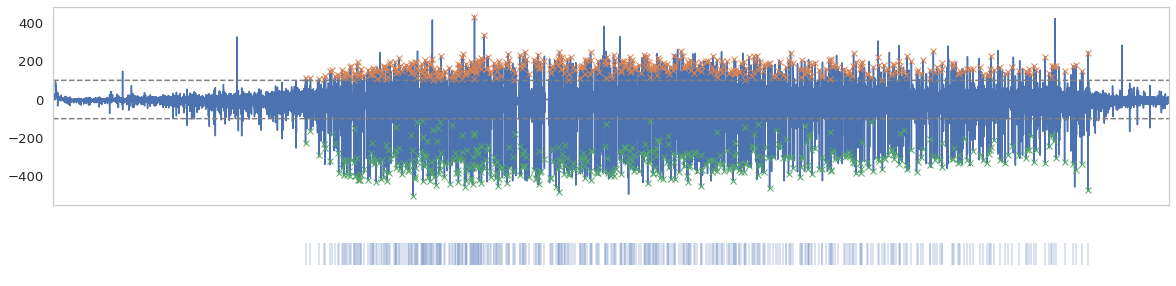

In [198]:
rec.set_sample_tresh(1e+02)
rec.calculate_sample_peaks()
rec.plot_peaks()
n_peaks = rec.get_neg_peaks()
data = rec.get_data()
